In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip3 install imutils
!pip3 install torchsummary
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import imutils
import cv2
from matplotlib import pyplot as plt
import PIL

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=b62e477dd32931588e1159696c7bf615028827f616421bb6803860ccdb9a565d
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
train_data_path = "../input/chest-xray-pneumonia/chest_xray/train"
val_data_path = "../input/chest-xray-pneumonia/chest_xray/val"

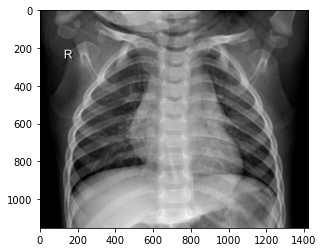

In [15]:
custom="../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0117-0001.jpeg"
import numpy as np
import cv2
im = cv2.imread(custom)
# print(im.shape)
plt.imshow(im)
plt.show()

In [4]:
img_transforms = transforms.Compose([
    
    # we resize the pictures
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])

img_transforms_train = transforms.Compose([
    
    # we resize the pictures
    transforms.Resize((256,256)),
    #transforms.RandomCrop(256),
    #transforms.RandomRotation(12),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
    ])

In [5]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms_train)

val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms)

In [6]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)

In [7]:
images,label=next(iter(train_data_loader))

In [8]:
for images,labels in train_data_loader:
    print(images.shape,labels)
    break

torch.Size([32, 3, 256, 256]) tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 1])


In [9]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 256x256x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 128x128x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 64x64x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 32x32x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (128 * 16 * 16 -> 4000)
        self.fc1 = nn.Linear(128 * 16 * 16, 16000)
        # linear layer (2000 -> 1000)
        self.fc2 = nn.Linear(16000, 8000)
        # linear layer (1000 -> 2)
        self.fc3 = nn.Linear(8000, 2)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
#         x = self.pool(F.relu(self.conv5(x)))
        # flatten image input
        x = x.view(-1, 128 * 16 * 16)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer, with relu activation function
        x = self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=16000, bias=True)
  (fc2): Linear(in_features=16000, out_features=8000, bias=True)
  (fc3): Linear(in_features=8000, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [10]:
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)


In [11]:
import numpy as np
n_epochs = 25
k = 0 
valid_loss_min = np.Inf
train,test=[],[]
for i in range(1, n_epochs+1):

    # keep track of training
    
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, label in train_data_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, label = images.cuda(), label.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
    
        with torch.no_grad():
            model.eval()
            for images,labels in val_data_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)


                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals = top_class ==labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train.append(train_loss/len(train_data_loader))
        test.append(test_loss/len(val_data_loader))

        print("epoch: {}/{}..".format(i, n_epochs),
                 "train loss: {:.3f}..".format(train_loss/len(train_data_loader)),
                  "test loss: {:.3f}".format(test_loss/len(val_data_loader)),
                  "test acc: {:.3f}".format(accuracy/len(val_data_loader)))
        
        
        if test_loss <= valid_loss_min:
            k+=1
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            test_loss))
            torch.save(model.state_dict(), 'model'+str(k)+'.pt')
            valid_loss_min = test_loss

epoch: 1/25.. train loss: 0.280.. test loss: 0.517 test acc: 0.750
Validation loss decreased (inf --> 0.516856).  Saving model ...
epoch: 2/25.. train loss: 0.124.. test loss: 1.137 test acc: 0.562
epoch: 3/25.. train loss: 0.096.. test loss: 0.785 test acc: 0.625
epoch: 4/25.. train loss: 0.096.. test loss: 0.773 test acc: 0.625
epoch: 5/25.. train loss: 0.089.. test loss: 0.706 test acc: 0.625
epoch: 6/25.. train loss: 0.094.. test loss: 0.682 test acc: 0.688
epoch: 7/25.. train loss: 0.076.. test loss: 1.226 test acc: 0.562
epoch: 8/25.. train loss: 0.068.. test loss: 0.711 test acc: 0.625
epoch: 9/25.. train loss: 0.073.. test loss: 0.658 test acc: 0.625
epoch: 10/25.. train loss: 0.070.. test loss: 0.884 test acc: 0.625
epoch: 11/25.. train loss: 0.065.. test loss: 0.862 test acc: 0.625
epoch: 12/25.. train loss: 0.063.. test loss: 0.514 test acc: 0.688
Validation loss decreased (0.516856 --> 0.514224).  Saving model ...
epoch: 13/25.. train loss: 0.068.. test loss: 0.421 test acc

In [12]:
test_data_path = "../input/chest-xray-pneumonia/chest_xray/test"

In [13]:
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [17]:
for  i in range(1,9):
    m1 = Net()
    m1.load_state_dict(torch.load("./model"+str(i)+".pt"))
    m1.eval()
#     print(m1)
    if train_on_gpu:
        m1.cuda()
    test=[]
    test_loss = 0
    accuracy = 0

    with torch.no_grad():
        m1.eval()
        for images,labels in test_data_loader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
            log_ps=m1(images)
            test_loss+=criterion(log_ps,labels)


            ps=torch.exp(log_ps)
            top_p,top_class=ps.topk(1,dim=1)
            equals = top_class ==labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))


        test.append(test_loss/len(val_data_loader))

        print("model"+str(i),
              "test loss: {:.3f}".format(test_loss/len(test_data_loader)),
                      "test acc: {:.3f}".format(accuracy/len(test_data_loader)))



model1 test loss: 0.416 test acc: 0.819
model2 test loss: 0.885 test acc: 0.741
model3 test loss: 0.780 test acc: 0.772
model4 test loss: 1.024 test acc: 0.741
model5 test loss: 0.877 test acc: 0.759
model6 test loss: 0.948 test acc: 0.758
model7 test loss: 1.073 test acc: 0.739
model8 test loss: 0.921 test acc: 0.777
